In [1]:
from dataclasses import dataclass, field
from typing import Optional

import logging
import sys
import torch
from copy import deepcopy

from torch.utils.data import DataLoader, Dataset
from transformers.trainer_utils import EvalLoopOutput, EvalPrediction

import datasets
import evaluate
import transformers
from datasets import load_dataset
from peft import LoraConfig, TaskType, get_peft_model, PeftModel
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    set_seed,
)

from qa_lib import (
    ModelArguments,
    DataTrainingArguments,
    QATrainer,
    adjust_training_args,
)
from models import (
    T5ForConditionalGeneration,
    DeployT5ForConditionalGeneration,
)
from util import (
    AdditionalArguments,
    update_autoconfig,
)

# from sequence_types.CheckSequenceTypeModule import CheckSequenceTypeModule
# from sequence_types.HiddenStatesSaver import HiddenStatesSaver

logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )
logger = logging.getLogger(__name__)

question_answering_column_name_mapping = {
    "squad": ("question", "context", "answer"),
    "squad_v2": ("question", "context", "answer"),
    "narrativeqa": ("question", "document", "answer")
}

%load_ext autoreload
%autoreload 2

/Users/maxbelitsky/miniconda3/envs/dl2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
additional_args = AdditionalArguments(
    use_synchronize=False,
    output_hidden_states_decoder=True,
    use_early_exit=True,
)
model_args = ModelArguments(
    model_name_or_path="./checkpoints/SQuAD/squad_t5_large_weighted_ce",
    tokenizer_name="google-t5/t5-large",
)
training_args = Seq2SeqTrainingArguments(
    output_dir="./save/squad_t5_large/",
    do_predict=False,
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=1,
    per_device_train_batch_size=1,
)
data_args = DataTrainingArguments(
    dataset_name="squad",
    context_column="context",
    question_column="question",
    answer_column="answers"
)


In [3]:
# Set the seed
set_seed(training_args.seed)

# Load the data
raw_datasets = load_dataset(
    data_args.dataset_name
)

# Load the model
if not additional_args.use_lora or training_args.do_train:
        config_name = model_args.config_name if model_args.config_name else model_args.model_name_or_path
        tokenizer_name = model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path
        model_name = model_args.model_name_or_path
else:
    lora_config = LoraConfig.from_pretrained(model_args.model_name_or_path)
    config_name = tokenizer_name = model_name = lora_config.base_model_name_or_path

if data_args.dataset_name in ["squad", "squad_v2", "narrativeqa"]:
    model_cls = T5ForConditionalGeneration if not additional_args.deploy_scenario else DeployT5ForConditionalGeneration

config = AutoConfig.from_pretrained(
    config_name,
)
config = update_autoconfig(
    config,
    additional_args,
    max_answer_length=data_args.max_answer_length
)
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_name,
    use_fast=model_args.use_fast_tokenizer,
)
model = model_cls.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_args.model_name_or_path),
    config=config,
)

# Save hidden states
# if model_args.save_hidden_states:

#     hidden_states_saver = HiddenStatesSaver()

#     model.encoder.embed_tokens = SentenceSaver(model.encoder.embed_tokens)
#     model.decoder.embed_tokens = SentenceSaver(model.decoder.embed_tokens)

#     plot_monotonicity = PlotMonotonicity(
#         tokenizer,
#         model.encoder.embed_tokens,
#         model.decoder.embed_tokens,
#         model_args.model_name_or_path
#     )

#     for module_idx, module in enumerate(model.decoder.block):
#         model.decoder.block[module_idx] = CheckMonotonicityModule(
#             module,
#             module_idx,
#             model.lm_head,
#             model.decoder.final_layer_norm,
#             plot_monotonicity,
#         )

# Load the model in LoRA
if additional_args.use_lora:
    if training_args.do_train:
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_2_SEQ_LM, r=additional_args.lora_rank, 
            lora_alpha=additional_args.lora_alpha, lora_dropout=additional_args.lora_dropout,
            target_modules=additional_args.lora_target_modules,
        )
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()
    else:
        model = PeftModel.from_pretrained(model, model_args.model_name_or_path, config=lora_config)
        model = model.merge_and_unload()


# Adjust the embedding size
embedding_size = model.get_input_embeddings().weight.shape[0]
if len(tokenizer) > embedding_size:
    model.resize_token_embeddings(len(tokenizer))


# Preprocessing the datasets.
# We need to tokenize inputs and targets.
if training_args.do_train:
    column_names = raw_datasets["train"].column_names
elif training_args.do_eval:
    column_names = raw_datasets["validation"].column_names
elif training_args.do_predict:
    column_names = raw_datasets["test"].column_names

# # Get the column names for input/target.
dataset_columns = question_answering_column_name_mapping.get(data_args.dataset_name, None)
if data_args.question_column is None:
    question_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
else:
    question_column = data_args.question_column

if data_args.context_column is None:
    context_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
else:
    context_column = data_args.context_column

if data_args.answer_column is None:
    answer_column = dataset_columns[2] if dataset_columns is not None else column_names[2]
else:
    answer_column = data_args.answer_column


# Temporarily set max_answer_length for training.
max_answer_length = data_args.max_answer_length
padding = "max_length" if data_args.pad_to_max_length else False
max_seq_length = min(data_args.max_seq_length, tokenizer.model_max_length)


# Preprocess the data
def preprocess_squad_batch(
    examples,
    question_column: str,
    context_column: str,
    answer_column: str,
):
    questions = examples[question_column]
    contexts = examples[context_column]
    answers = examples[answer_column]

    def generate_input(_question, _context):
        return " ".join(["question:", _question.lstrip(), "context:", _context.lstrip()])

    inputs = [generate_input(question, context) for question, context in zip(questions, contexts)]
    targets = [answer["text"][0] if len(answer["text"]) > 0 else "" for answer in answers]
    return inputs, targets


def preprocess_function(examples):
    if "squad" in data_args.dataset_name:
        inputs, targets = preprocess_squad_batch(examples, question_column, context_column, answer_column)
    # elif data_args.dataset_name == "narrativeqa":
    #     inputs, targets = preprocess_narrativeqa_batch(examples, question_column, context_column, answer_column)
        
    model_inputs = tokenizer(inputs, max_length=max_seq_length, padding=padding, truncation=True)
    # Tokenize targets with text_target=...
    labels = tokenizer(text_target=targets, max_length=max_answer_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length" and data_args.ignore_pad_token_for_loss:
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Validation preprocessing
def preprocess_validation_function(examples):            
    if "squad" in data_args.dataset_name:
        inputs, targets = preprocess_squad_batch(examples, question_column, context_column, answer_column)
        model_inputs = tokenizer(inputs, max_length=max_seq_length, padding=padding, truncation=True,
                                    return_overflowing_tokens=True, return_offsets_mapping=True,)

    # elif data_args.dataset_name == "narrativeqa":
    #     inputs, targets = preprocess_narrativeqa_batch(examples, question_column, context_column, answer_column)
    #     model_inputs = tokenizer(inputs, max_length=max_seq_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=targets, max_length=max_answer_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length" and data_args.ignore_pad_token_for_loss:
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]
    
    if "squad" in data_args.dataset_name:
        # Since one example might give us several features if it has a long context, we need a map from a feature to
        # its corresponding example. This key gives us just that.
        sample_mapping = model_inputs.pop("overflow_to_sample_mapping")

        # For evaluation, we will need to convert our predictions to substrings of the context, so we keep the
        # corresponding example_id and we will store the offset mappings.
        model_inputs["example_id"] = []
        # Augment the overflowing tokens to the labels
        labels_out = []
        for i in range(len(model_inputs["input_ids"])):
            # One example can give several spans, this is the index of the example containing this span of text.
            sample_index = sample_mapping[i]
            model_inputs["example_id"].append(examples["id"][sample_index])
            labels_out.append(labels["input_ids"][sample_index])

        model_inputs["labels"] = labels_out
        
    elif data_args.dataset_name == "narrativeqa":
        model_inputs["labels"] = labels["input_ids"]
        
    return model_inputs


if training_args.do_train:
    if "train" not in raw_datasets:
        raise ValueError("--do_train requires a train dataset")
    train_dataset = raw_datasets["train"]
    if data_args.max_train_samples is not None:
        # We will select sample from whole data if agument is specified
        max_train_samples = min(len(train_dataset), data_args.max_train_samples)
        train_dataset = train_dataset.select(range(max_train_samples))
    # Create train feature from dataset
    with training_args.main_process_first(desc="train dataset map pre-processing"):
        train_dataset = train_dataset.map(
            preprocess_function,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running tokenizer on train dataset",
        )
    if data_args.max_train_samples is not None:
        # Number of samples might increase during Feature Creation, We select only specified max samples
        max_train_samples = min(len(train_dataset), data_args.max_train_samples)
        train_dataset = train_dataset.select(range(max_train_samples))

if training_args.do_eval:
    if "validation" not in raw_datasets:
        raise ValueError("--do_eval requires a validation dataset")
    eval_examples = raw_datasets["validation"]
    if data_args.max_eval_samples is not None:
        # We will select sample from whole data
        max_eval_samples = min(len(eval_examples), data_args.max_eval_samples)
        eval_examples = eval_examples.select(range(max_eval_samples))
    # Validation Feature Creation
    with training_args.main_process_first(desc="validation dataset map pre-processing"):
        eval_dataset = eval_examples.map(
            preprocess_validation_function,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running tokenizer on validation dataset",
        )
    if data_args.max_eval_samples is not None:
        # During Feature creation dataset samples might increase, we will select required samples again
        max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
        eval_dataset = eval_dataset.select(range(max_eval_samples))

if training_args.do_predict:
    if "test" not in raw_datasets:
        raise ValueError("--do_predict requires a test dataset")
    predict_examples = raw_datasets["test"]
    if data_args.max_predict_samples is not None:
        # We will select sample from whole data
        predict_examples = predict_examples.select(range(data_args.max_predict_samples))
    # Predict Feature Creation
    with training_args.main_process_first(desc="prediction dataset map pre-processing"):
        predict_dataset = predict_examples.map(
            preprocess_validation_function,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running tokenizer on prediction dataset",
        )
    if data_args.max_predict_samples is not None:
        # During Feature creation dataset samples might increase, we will select required samples again
        max_predict_samples = min(len(predict_dataset), data_args.max_predict_samples)
        predict_dataset = predict_dataset.select(range(max_predict_samples))

# # Data collator
label_pad_token_id = -100 if data_args.ignore_pad_token_for_loss else tokenizer.pad_token_id
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8 if training_args.fp16 else None,
)

# Metric
metric = evaluate.load("squad_v2" if data_args.version_2_with_negative else "squad")
        
def compute_metrics(p, prefix: str = None):
    metric_dict = metric.compute(predictions=p.predictions, references=p.label_ids)
    metric_keys = deepcopy(list(metric_dict.keys()))
    for key in metric_keys:
        if prefix is not None and prefix not in key:
            metric_dict['{}_{}'.format(prefix, key)] = metric_dict.pop(key)
    return metric_dict

# Post-processing
def post_processing_function(
    examples: datasets.Dataset, features: datasets.Dataset, outputs: EvalLoopOutput, stage="eval"
):
    # Decode the predicted tokens.
    preds = outputs.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    feature_per_example = {example_id_to_index[feature["example_id"]]: i for i, feature in enumerate(features)}
    predictions = {}

    task_name = "squad_v2" if data_args.version_2_with_negative else "squad"

    # Let's loop over all the examples!
    for example_index, example in enumerate(examples):
        # This is the index of the feature associated to the current example.
        feature_index = feature_per_example[example_index]
        predictions[example["id"]] = decoded_preds[feature_index]

    # Format the result to the format the metric expects.
    if data_args.version_2_with_negative:
        formatted_predictions = [
            {"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in predictions.items()
        ]
    else:
        formatted_predictions = [{"id": k, "prediction_text": v} for k, v in predictions.items()]

    references = [{"id": ex["id"], "answers": ex[answer_column]} for ex in examples]
    return EvalPrediction(predictions=formatted_predictions, label_ids=references)

# adjust training arguments
training_args = adjust_training_args(training_args, data_args, additional_args)

# Initialize our Trainer
trainer_cls = QATrainer
trainer = trainer_cls(
    model=model,
    args=training_args,
    train_dataset=train_dataset if training_args.do_train else None,
    eval_dataset=eval_dataset if training_args.do_eval else None,
    eval_examples=eval_examples if training_args.do_eval else None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics, # if training_args.predict_with_generate else None,
    post_process_function=post_processing_function if "squad" in data_args.dataset_name else None,
)

# Evaluation
results = {}
max_length = (
    training_args.generation_max_length
    if training_args.generation_max_length is not None
    else data_args.val_max_answer_length
)
num_beams = data_args.num_beams if data_args.num_beams is not None else training_args.generation_num_beams

# if training_args.do_eval:
#     logger.info("*** Evaluate ***")
#     metrics = trainer.evaluate(max_length=max_length, num_beams=num_beams, metric_key_prefix="eval")

#     max_eval_samples = data_args.max_eval_samples if data_args.max_eval_samples is not None else len(eval_dataset)
#     metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))



/Users/maxbelitsky/miniconda3/envs/dl2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# For each hidden state, compute similarity with other hidden states
# Compute mean similarity for all hidden states for this token
# Find the token with the highest similarity

In [4]:
from sequence_types.sequence_types import get_first_similar_state, compute_hidden_state_similarities

In [5]:
results = compute_hidden_state_similarities(
    eval_dataset, trainer, tokenizer, max_examples=3, max_sequence_length=30
)

0it [00:00, ?it/s]You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
3it [00:04,  1.50s/it]


In [ ]:
# Split into 3 buckets: first similar state is the first, the last or in the middle
# Split 24/3 = 8 (every 8 layers)

In [16]:
# Check strict monotonicity
# torch.diff(hidden_satate_similaritites[0], prepend=torch.tensor([0])).count_nonzero()

In [38]:
max_means = [results[i]["mean_similarity"].max().item() for i in results]
min_means = [results[i]["mean_similarity"].min().item() for i in results]

easy_token_examples = torch.argsort(torch.tensor(max_means), descending=True)
hard_token_examples = torch.argsort(torch.tensor(min_means))

In [39]:
easy_token_examples[:10], hard_token_examples[:10]

(tensor([396,   8,   5, 403,  29, 389, 458, 444, 406, 397]),
 tensor([289, 251, 134, 150, 140, 441, 305, 310, 432, 317]))

In [43]:
results[403]

{'hidden_satate_similaritites': tensor([[0.6826, 0.6829, 0.7265, 0.7818, 0.8085, 0.8210, 0.8360, 0.8397, 0.8459,
          0.8465, 0.8615, 0.8599, 0.8498, 0.8647, 0.8648, 0.8710, 0.8962, 0.9421,
          0.9582, 0.9761, 0.9832, 0.9919, 0.9969],
         [0.6571, 0.6841, 0.6471, 0.6311, 0.6200, 0.6537, 0.6741, 0.6798, 0.7118,
          0.7391, 0.7787, 0.7616, 0.7491, 0.7891, 0.8113, 0.8446, 0.8718, 0.9061,
          0.9328, 0.9608, 0.9727, 0.9871, 0.9966],
         [0.8022, 0.7389, 0.7195, 0.7220, 0.7470, 0.7570, 0.7711, 0.7716, 0.7823,
          0.7893, 0.8184, 0.8288, 0.8240, 0.8536, 0.8730, 0.8931, 0.9097, 0.9321,
          0.9405, 0.9618, 0.9715, 0.9851, 0.9955]]),
 'generated_ids': [689, 1549, 49],
 'generated_answer': 'linebacker',
 'n_similar_states': tensor([6, 6, 7]),
 'mean_similarity': tensor([0.8603, 0.7852, 0.8430]),
 'first_similar_state': tensor([[17],
         [17],
         [16]]),
 'actual_answer': 'linebacker'}

In [48]:
tokenizer.decode(1797)

'October'

In [47]:
results[134]

{'hidden_satate_similaritites': tensor([[0.6395, 0.6668, 0.7539, 0.7756, 0.8112, 0.8402, 0.8506, 0.8560, 0.8560,
          0.8565, 0.8601, 0.8682, 0.8710, 0.8752, 0.8818, 0.8866, 0.8939, 0.9325,
          0.9534, 0.9739, 0.9830, 0.9908, 0.9967],
         [0.5823, 0.5702, 0.5948, 0.5652, 0.5837, 0.6246, 0.6714, 0.6920, 0.6727,
          0.6876, 0.7275, 0.7556, 0.7716, 0.7931, 0.7882, 0.8133, 0.8178, 0.8826,
          0.9339, 0.9538, 0.9657, 0.9808, 0.9927],
         [0.7152, 0.6590, 0.6561, 0.6659, 0.7020, 0.7419, 0.7408, 0.7687, 0.7563,
          0.7591, 0.8019, 0.8112, 0.8089, 0.8171, 0.8136, 0.8256, 0.8515, 0.9053,
          0.9443, 0.9657, 0.9774, 0.9876, 0.9947]]),
 'generated_ids': [1797, 11940, 1673],
 'generated_answer': 'October 16, 2012',
 'n_similar_states': tensor([6, 5, 6]),
 'mean_similarity': tensor([0.8641, 0.7574, 0.8117]),
 'first_similar_state': tensor([[17],
         [18],
         [17]]),
 'actual_answer': 'October 16, 2012'}

In [41]:
8

8

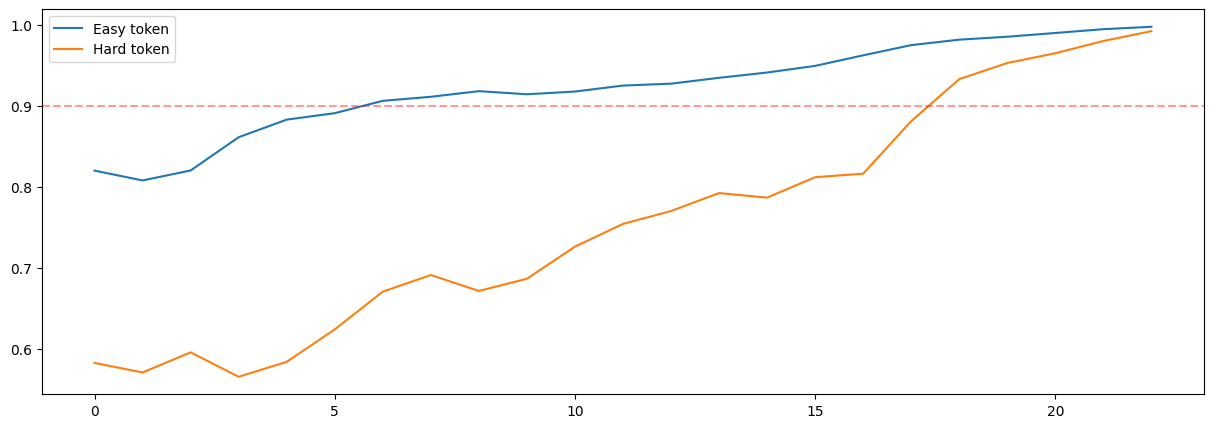

In [367]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(results[102]['hidden_satate_similaritites'][2], label=f"Easy token")
plt.plot(results[134]['hidden_satate_similaritites'][1], label=f"Hard token")
plt.axhline(0.9, color='r', linestyle='--', alpha=0.4)
plt.legend()

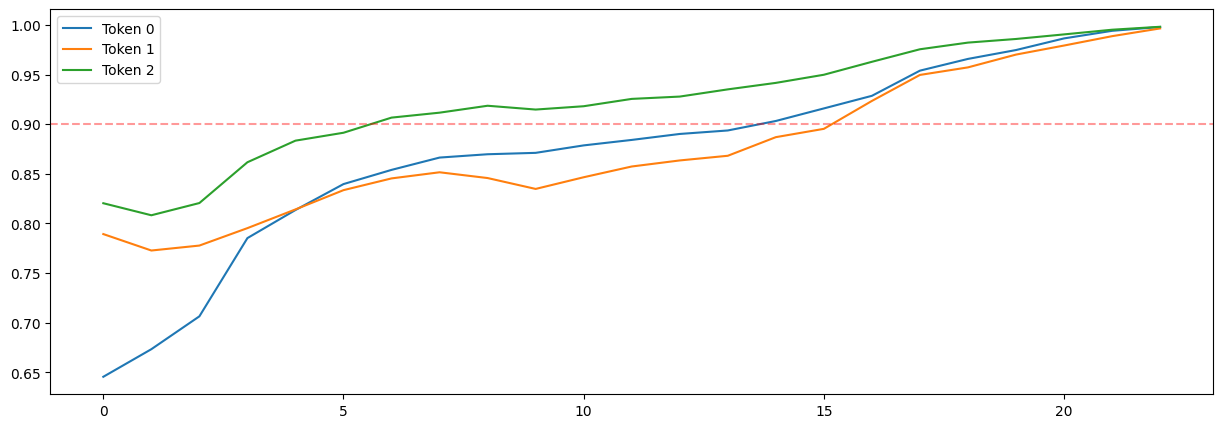

In [363]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, v in enumerate(results[102]['hidden_satate_similaritites']):
    plt.plot(v, label=f"Token {i}")
plt.axhline(0.9, color='r', linestyle='--', alpha=0.4)
plt.legend()